# Stellar Population Photometric Synthesis with Artificial Intelligence as revealed by S-PLUS

### Student: Vitor Martins Cernic
### NUSP: 9847710

<font color='red'> This notebook is being submitted as the Term Project, required for the conclusion of the course AGA5926 - Astronomical databases and astrostatistics in the era of Big Data. </font>

---

# 1. Introduction

As technology evolves, telescopes are ever more capable of producing high quality data in much higher volume. In the last decade, surveys like Sloan Digital Sky Survey were able to generate ~200 GB of data each night. Today's generation of telescopes (e.g. LSST, TMT) are expected to produce 30-90 TB of data **each night**. This is an incredible ammount of information, and astronomers are in need of highly-efficient tools that can reliably extract information without the need of classical time consuming processes.

In this project, we want to automate the process of predicting intrinsical stellar population parameters (such as stellar mass or mean star age) from photometry. These parameters are usually extracted from the spectra with softwares such as STARLIGHT or FADO. What we aim to do here is to skip the need for the spectra altogether and use only the photometry to obtain these parameters. For this, we will make use of Artificial Intelligence and a large sample of training data.

Troughout the course of this notebook, we will provide a network that can reliably predict a number of diferent STARLIGHT parameters directly from S-PLUS photometry.

--- 

# 2. The libraries

For this project we will make use of many different python libraries. The first 3 (pandas, numpy and matplotlib) are all used for data storage and visualization. Keras and Tensorflow will be used as the main framework for our machine learning model. AstroML and SKlearn will be used to facilitate some operations.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import keras
import tensorflow as tf
import tensorflow.keras.backend as K
from keras import models
from keras import layers

from astroML.utils import split_samples
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

---

# 1. The data

As with any machine learning problem, we need data. Remember that we want to have the S-PLUS photometries as inputs and STARLIGHT parameters as outputs.

Let us start with the outputs: the STARLIGHT parameters. We will be using the results obtained form Ariel Werle's PhD thesis (Werle A., 2019). Werle applied a modified version of the STARLIGHT software to ~200,000 objects, using a combined spectra from SDSS and GALEX to improve both the UV and continuum emission. This application provided us with the necessary parameters estimation for a lot of galaxies.

The DR2 photometries were gathered directly from the S-PLUS cloud website. We decided to use the PETRO apertures as these had the best results for photometric redshift estimations. In the future we want to update to the iDR3 database and try different apertures.

We also noticed from our internal testing that the redshift played an important role in determining the STARLIGHT parameters. Because of this, we decided to also use the SDSS spectroscopic redshift for each object. We intend to change these spectroscopic redshifts in our training data to photometric redshifts from Erik Vinicius' estimations based on S-PLUS photometry.

Finally, we crossmatched Werle's STARLIGHT estimations with S-PLUS objects based on RA and Dec with the help of TOPCAT. This yielded a database with 55,778 galaxies, each one containing 13 features (12 S-PLUS photometries + 1 spectroscopic redshift) and 19 STARLIGHT parameters (e.g. stellar mass, mean star age, *etc*). This crossmatch can be downloaded as a file from the same Github as this notebook (https://github.com/vcernic/AGA5926-final-project).

In this section we will do the following:
* Read the data file
* Define which parameter we will study
* Visualize the training data
* Normalize and split the data

## Reading the data

Reading files is made easier with the use of external libraries such as Pandas.

In [2]:
# Reading the file
file = 'splus_starlight.dat'
data = pd.read_csv(file, sep=',', engine='python')

data.describe()

,Unnamed: 0,id,ra,dec,uJAVA_petro,F378_petro,F395_petro,F410_petro,F430_petro,g_petro,...,S2NHa,umg,gmr,rmi,imz,mlr,Mstar,log_b,SSFRb,SSFRc
count,55778.000000,55778.000000,55778.000000,55778.000000,55778.000000,55778.000000,55778.000000,55778.000000,55778.000000,55778.000000,...,55778.000000,55778.000000,55778.000000,55778.000000,55778.000000,55778.000000,55778.000000,55778.000000,55778.000000,55778.000000
mean,27888.500000,291479.578795,138.261698,0.003929,20.027480,19.776944,19.621488,19.431895,19.178932,18.650498,...,36.984750,1.323102,0.560571,0.262241,0.178218,1.571301,10.600462,-169.813163,-178.230325,-138.190520
std,16101.865994,174853.288944,146.682342,0.734657,1.353488,1.323116,1.366666,1.363853,1.361769,1.249139,...,40.734863,0.968635,0.315002,0.217835,0.367237,1.096380,0.870424,374.786195,370.981725,331.246596
min,0.000000,48620.000000,0.000687,-1.281977,9.860000,9.530000,9.430000,8.120000,8.140000,7.010000,...,0.000000,-14.087000,-3.779000,-22.495000,-18.823000,0.008000,6.025000,-999.000000,-999.000000,-999.000000
25%,13944.250000,73180.250000,22.874415,-0.644748,19.320000,19.100000,18.910000,18.740000,18.490000,18.000000,...,4.295000,0.905000,0.409000,0.211000,0.106000,0.722250,10.063000,-1.720750,-11.857000,-11.841000
50%,27888.500000,332732.500000,46.664410,0.018051,20.040000,19.800000,19.640000,19.470000,19.240000,18.720000,...,24.578500,1.179000,0.558000,0.271000,0.227000,1.279000,10.693000,-0.491000,-10.628000,-10.739000
75%,41832.750000,388093.750000,323.960915,0.637534,20.760000,20.500000,20.370000,20.190000,19.970000,19.450000,...,54.352000,1.548000,0.713000,0.336000,0.302000,2.229000,11.210000,0.101000,-10.036000,-10.144000
max,55777.000000,915570.000000,359.997864,1.273265,31.020000,28.690000,29.160000,28.800000,29.130000,25.070000,...,398.506000,23.285000,23.643000,6.326000,23.042000,6.406000,13.931000,2.747000,-7.390000,-8.009000


Let's take a look at the distribution of our 13 features (12 S-PLUS filters + redshift)

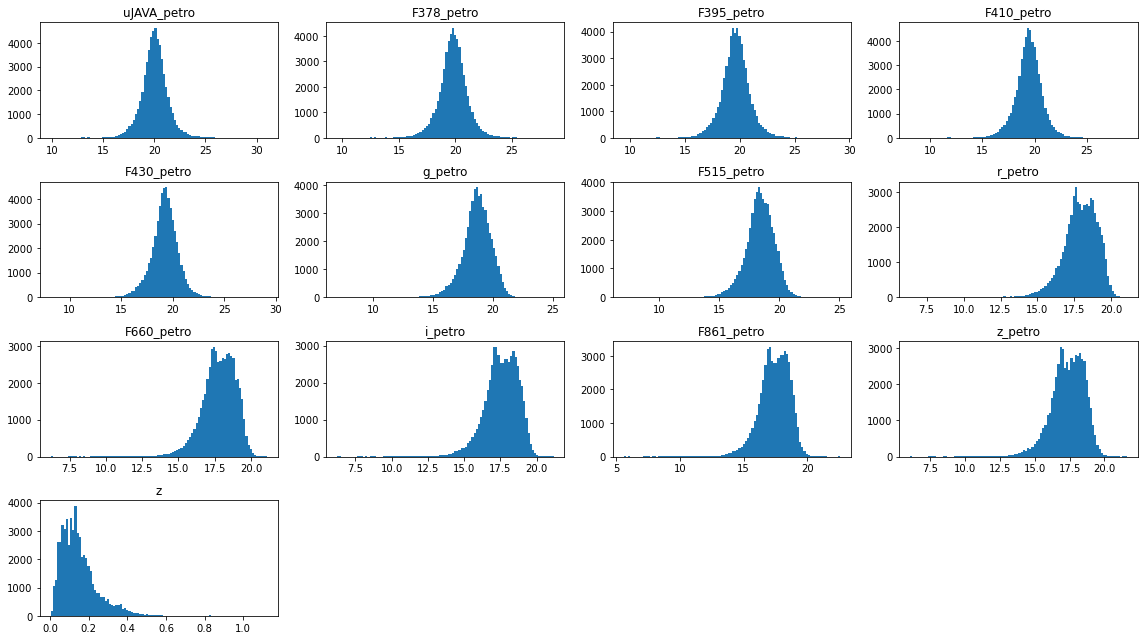

In [3]:
# Defining the 12 bands + z redshift
features = ['uJAVA_petro', 'F378_petro', 'F395_petro', 'F410_petro',
            'F430_petro', 'g_petro', 'F515_petro', 'r_petro', 'F660_petro',
            'i_petro', 'F861_petro', 'z_petro', 'z']  # 12 filter + 1 z

# Plotting all filters
fig, axs = plt.subplots(nrows = 4, ncols = 4, figsize=(16,9))

for i in range(3):
    for j in range(4):
        axs[i][j].hist(data[features[(i)*4 + j]], bins=100)
        axs[i][j].set_title(features[(i)*4 + j])

# Plotting the redshift distribution
axs[3][0].hist(data[features[-1]], bins=100)
axs[3][0].set_title(features[-1])

# Deleting extra axes
for i in range(1,4): 
    fig.delaxes(axs[3][i])

plt.tight_layout()
plt.show()


## Defining the expected parameter

In this notebook we will only be studying the stellar mass (**Mstar**) parameter. Other parameters should present similar results.


In [4]:
# The parameter that we will be studying
param = 'Mstar'

if param in data.columns:
    print(f"All good to go! {param} is a valid parameter")
else:
    raise ValueError("Something is wrong. You need to choose a valid parameter from data.columns!")

All good to go! Mstar is a valid parameter


Let's take a look at the target parameter data to see its distribution.

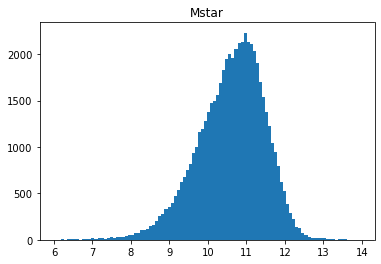

In [5]:
plt.hist(data[param], bins=100)
plt.title(param)
plt.show()

## Normalizing and splitting the data

Instead of having the network train on data that fits in different ranges, it usually a good idea to normalize the data between 0 and 1. This normally helps the network learn, and to accomplish this we will use sklearn MinMaxScaler to make this linear transformation more efficiently on both the features and the targets.

Note that at the end of the project we want to run through the model some S-PLUS data that is NOT normalized. This means that for us to have a more robust perception of how the model will perform we need to remove test data from the initial normalization of the training set. This test set will be separeted from all training, and will be used to estimate the final model's performance at the end of the notebook.

In [6]:
# Seprating the data into two sets: train and test (80% train and 20% test split)
(data_train, data_test) , (targets_train, targets_test) = split_samples(data[features], data[param], 
                                                                        [0.8, 0.2],
                                                                        random_state = 1234) # for reproducibility

# Targets need to be reshaped for Keras to read
targets_train = np.reshape(targets_train, (-1, 1))
targets_test  = np.reshape(targets_test, (-1, 1))

In [7]:
# Scaling the data

# Generating the scalers
scaler_data = MinMaxScaler()
scaler_targets = MinMaxScaler()

# Fitting the scalers into the train data 
scaler_data.fit(data_train)
scaler_targets.fit(targets_train)

# Scaling train and test sets
data_train = scaler_data.transform(data_train)
data_test  = scaler_data.transform(data_test)

targets_train = scaler_targets.transform(targets_train)
targets_test  = scaler_targets.transform(targets_test)

---

# 2. The Model

We can easily categorize our problem as a Regression problem. Remember that the final goal of this project is to create a network that can take a given S-PLUS photometry and return a single galaxy parameter. There are many ways that we can approach a regression problem: with Neural Networks, with Classical Machine Learning models (e.g. Random Forest), *etc*. Here we are going to apply a simple Neural Network. 

Here are the steps we will follow in this section:
* Create a builder for the Neural Network
* Run a K-Fold Cross-Validation for a high number of epochs
* Analyze the history of the network

## Building the Network

The network I present here is a simple Neural Network with just 2 hidden activation layers. After testing some other architectures with more complexity (e.g. more layers) this is the best configuration I found, though I should mention that I've yet to try some more complex activation layers like DenseVariational. I also tested a few classical Machine Learning models, such as Random Forest Regressor, but it didn't perform as well as a Neural Network. This exact configuration of the network was inspired by the "Boston Housing problem" tackled by François Chollet in his book "Deep Learning with Python". 

There was some testing regarding where the Dropout layers should be placed (before or after activation). I had almost identical results in both cases, and it seems that this is something related to the ReLU activation itself as explained by Sebastian Raschka in his Machine Learning FAQs (https://sebastianraschka.com/faq/docs/dropout-activation.html). At the end I decided to place it after each activation layer, though this decision seemed mostly irrelevant. The value for the Dropout was set at 30% after some hyperparameter optimization and this seems to be within the community consensus of best Dropout values for Regression.

Eventhough I spent some time doing hyperparameter optimization (number of neurons, lerning rate, batch size, *etc*.) I will not be putting any code for optimization here just because it is not the objective of the project. I just want to make a point that the values set for the hyperparameters were not chosen at random, and each one of them was thoroughly discussed. 

Now that we have some idea of why this specific network was chosen, let's make a function to build it! Note that the data is passed as an argument so that the input shape can be properly set.

In [8]:
def build_network(data_train):
    '''Builds the network model'''

    model = models.Sequential()
    model.add(layers.Dense(128, activation='relu',
                           input_shape=(data_train.shape[1],)))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1))
    
    opt = keras.optimizers.Adam(learning_rate = 0.0001)
    model.compile(optimizer=opt, loss='mse', metrics=['mae', 'mse'])
    
    return model

The network will calculate, at each epoch, the Mean Average Error (MAE) and Mean Squared Error (MSE) of the (hopefully) unbiased validation set. These are normally the best metrics to use for evaluating Regression models, as both of them give us some perspective of the error between the values predicted by the network and the "true" targets set by the database. The main difference between these two metrics is that the MAE is more robust to data with outliers, while the MSE is normally better for converging as we move closer to the loss minima. 

A decision has to be made as to which one of those metrics will be used as the loss function. In Regression models, the MAE and MSE loss are generally called L1 and L2 loss, respectively. There is no "superior loss", as each one has its pros and cons, but for the Mstar parameter specifically I will be using the L2 loss as it had some better results. Despite this decision, I should mention that I neglected some other more complex loss functions that could be tested, such as Smooth Mean Absolute Error (Huber Loss), for the sake of simplicity.

## Using K-Fold Cross-Validation

***Disclaimer: the next block might take several minutes to run. In my computer, it took ~20 minutes.***

If we want to have a good understanding of the performance of a network, K-Fold is normally a good way to do it. 

In most simple Machine Learning applications, people just separate a percentage of the total dataset for training and the rest for testing/validation (*sidenote: testing and validation are often perceived as being the same, which is not true*). This is normally fine if you have a small dataset or is trying to solve a simple problem, but as your need for a proper performance evaluation gets higher this method starts to lack precision. A good way for measuring the performance of the network would be to run the model with different training sets. But you may ask yourself *"how can you do that without generating more data?"* The answer is quite simple: separate your whole dataset into various non-intersecting groups and train the network a lot of times, each iteration selecting a different group to be the validation set and the rest to be the training set. This is essentially what the K-Fold Cross-Validation is about: separating your dataset into "K" different "folds" and "cross-validating" them. 

These cross-validating methods have an obvious problem related to the ammount of processing time needed. Each time you iterate through your folds, you have to run the model from scratch. This means that the ammount of time necessary to run your K-Fold increases linearly the more splits you make. While this won't be much of a problem in this exact project, if you're trying to solve a complex problem the ammount of processing required can very easily surpass absurd time scales. 

For the sake of time, I will use K-Fold Cross-Validation as the method for evaluating the model. I want to note that many other robust cross-validation methods are available: Leave One Out (LOOCV), Shuffle & Split, *etc*, but most of them require much larger ammounts of time to be consumed. 

The split made here will be for 8 folds. This means that as the total training data is 80% of the whole dataset, each fold will have 70% of the whole for training and 10% for validation. 

In the next block of code, each one of the 8 K-Fold iterations goes through the following steps:
* Separate a new training and validation set
* Compile a fresh new model
* Fit the model to the training set
* Save the history of the fold for later analysis

Each fold will run for 500 epochs so we can both understand their performance and look at the best value for the number of epochs! Now, let's run some K-fold!

In [9]:
# Variables for storing data during the K-Fold
all_histories = []
fold_number = 0

# Starting the K-Fold loop!
for train, val in KFold(n_splits = 8).split(data_train, targets_train):
    
    # Cleaning cluttering memory data used by Keras 
    K.clear_session()
    
    # Building the model
    model = build_network(data_train)
    
    # Print for user feedback
    print(f'------ Training fold number {fold_number} ------')
    
    # Training the model
    history = model.fit(data_train, targets_train,
                        validation_data=(data_train[val], targets_train[val]),
                        epochs=500, batch_size=128, verbose=0)
    
    # Storing relevant validation data
    all_histories.append(history.history)
    
    fold_number += 1
    
print("\n****** Training Completed! ******")

------ Training fold number 0 ------
------ Training fold number 1 ------
------ Training fold number 2 ------
------ Training fold number 3 ------
------ Training fold number 4 ------
------ Training fold number 5 ------
------ Training fold number 6 ------
------ Training fold number 7 ------

****** Training Completed! ******


## Analyzing the results

After letting our network run with different training sets for a large ammount of time, we can look at the data and see at what epoch the network starts overfitting. This is done so we can find what is best number of epochs that we should run our final model to give us the best result.

To find the best number of epochs, we will look at the history of our loss, which is the MSE. This is normally a fairly subjective decision: we should look for the epoch where the validation loss is at its minimum before it starts increasing due to overfitting. Because I want to try to make a fully working code without any human input, I'll define the best epoch as the one that has the lowest average loss from all 8 folds. A better analysis could be made taking into account the loss of the surrounding epochs, but I didn't have time to inplement it.

Note that the information about each epoch's validation loss (and all other metrics) is stored inside the "history" variable. 

In [10]:
# Calculating the average loss history between all 8 folds
average_train_loss_history = [np.mean([h["loss"][i] for h in all_histories]) for i in range(500)]
average_val_loss_history = [np.mean([h["val_loss"][i] for h in all_histories]) for i in range(500)]

# Finding the best value for the number of epochs
best_epoch = average_val_loss_history.index(min(average_val_loss_history)) + 1 # +1 because index is >= 0, while epoch is > 0 

Let's visualize the best number of epochs and the loss history!

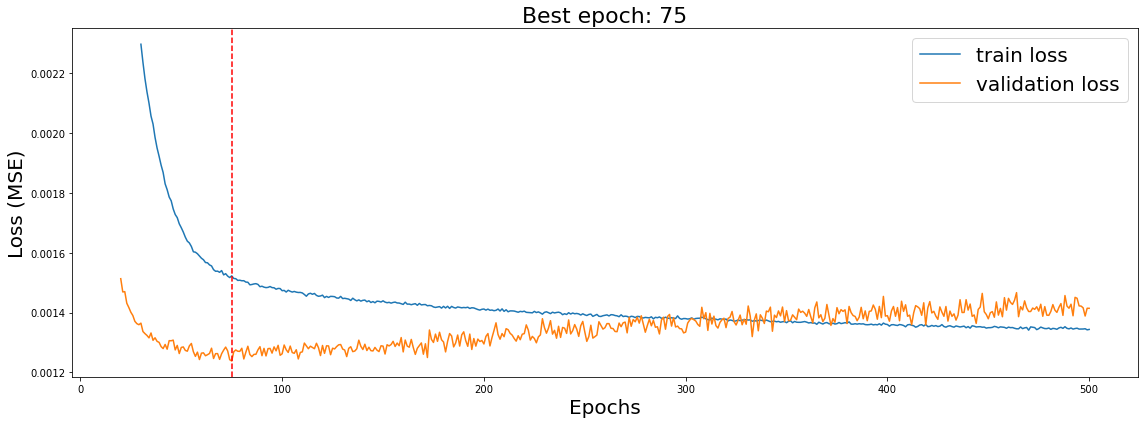

In [11]:
# Plotting the validation loss for all 500 epochs
fig = plt.figure(figsize=(16,6))
plt.plot(range(30, len(average_train_loss_history) + 1), average_train_loss_history[29:], label='train loss')
plt.plot(range(20, len(average_val_loss_history) + 1), average_val_loss_history[19:], label='validation loss')
plt.axvline(best_epoch, c='r', ls='--')
plt.title(f"Best epoch: {best_epoch}", fontsize=22)
plt.xlabel("Epochs", fontsize=20)
plt.ylabel("Loss (MSE)", fontsize=20)
plt.legend(fontsize=20)
plt.tight_layout()
plt.show()

Now that the best number of epochs is set, we can look at how much the different folds changed within that epoch. This is done to have a better perspective of how much the model can variate due to different datasets.

In [12]:
# Printing scores for each fold at the best epoch
print(f"Score per fold at epoch {best_epoch}")
print("-----------------------------------------")
loss_array = []
fold_no = 1

for fold_history in all_histories:
    mse = fold_history['val_loss'][best_epoch-1]
    print(f"> Fold {fold_no} - " + "Loss: {:.5f} - RMSE: {:.5f}".format(mse, np.sqrt(mse)))
    print("-----------------------------------------")
    loss_array.append(mse)
    fold_no += 1

print(f"\nAverage Loss: {np.mean(loss_array)} (+- {np.std(loss_array)})")
print(f"Average RMSE: {np.mean([np.sqrt(x) for x in loss_array])} (+- {np.std([np.sqrt(x) for x in loss_array])})\n")

Score per fold at epoch 75
-----------------------------------------
> Fold 1 - Loss: 0.00121 - RMSE: 0.03478
-----------------------------------------
> Fold 2 - Loss: 0.00115 - RMSE: 0.03387
-----------------------------------------
> Fold 3 - Loss: 0.00119 - RMSE: 0.03448
-----------------------------------------
> Fold 4 - Loss: 0.00125 - RMSE: 0.03531
-----------------------------------------
> Fold 5 - Loss: 0.00128 - RMSE: 0.03581
-----------------------------------------
> Fold 6 - Loss: 0.00130 - RMSE: 0.03600
-----------------------------------------
> Fold 7 - Loss: 0.00129 - RMSE: 0.03593
-----------------------------------------
> Fold 8 - Loss: 0.00124 - RMSE: 0.03528
-----------------------------------------

Average Loss: 0.0012382355926092714 (+- 4.968071265654826e-05)
Average RMSE: 0.03518141510933187 (+- 0.0007096643672518464)



As we can see, the deviation for each fold is on average ~2%.

---
# 3. The Test data

From the previous analysis we found that the model behaves very well with this kind of data. We also studied the best number of epochs for it to run. Now, to have a final measure of performance of what the model can achieve we can use the test data we kept separated since the beggining of this notebook. This last performance test is trying to simulate how the model will behave when we apply new, unknown S-PLUS data. 

Here are the steps we will follow in this section:
* Train a brand new model
* Measure performance with test data
* Visualize a predict plot

## Training a new model

The first step to obtain a good performance test is to compile a fresh new model from scratch and train it with all available data. This means that instead of splitting the train data into train and validation (like we did in the K-Fold) we will use the whole dataset to train this model. The validation set is just used as a way to measure the network performance throughout the epochs, but we don't need that information anymore as we will be measuring the network performance via the test set, which is already separated.

In [13]:
# Cleaning cluttering data from Keras 
K.clear_session()

# Building the model
model = build_network(data_train)

# Training the model
model.fit(data_train, targets_train,
          epochs=best_epoch, batch_size=128, verbose=0)

print("Model trained successfully!")

Model trained successfully!


## Evaluating with the test set

After the final model has trained, we can estimate the final performance measurements using the test dataset.

It is important to note that the final performance metrics (MAE, RMSE, *etc*) should be calculated using un-normalized results. The metrics that we used while training of the network doesn't hold any physical value apart from telling us how the network performs in comparison with itself (or with another network using the same training/test set).

In [14]:
# Evaluating the performance of the model for the test set
results = model.evaluate(data_test, targets_test, batch_size=128, verbose = 0)

In [15]:
# Predicting the parameter with the test data
predict_test = model.predict(data_test)

# Scaling back both the prediction and the targets
x = scaler_targets.inverse_transform(predict_test)
y = scaler_targets.inverse_transform(targets_test)

# Printing out the metrics
print("====== Test Predict Metrics ======")
print("Test MAE =", mean_absolute_error(y,x))
print("Test MSE =", mean_squared_error(y,x))
print("Test RMS =", np.sqrt(mean_squared_error(y,x)))
print("Test  R2 =", r2_score(y,x))

print("\n====== Test Targets Info ======")
print("Mean   =", np.mean(y), "+-", np.std(y))
print("Median =", np.median(y), "+-", np.std(y))

====== Test Predict Metrics ======
Test MAE = 0.1897675375728122
Test MSE = 0.08049254107154724
Test RMS = 0.2837120742434964
Test  R2 = 0.8942660211711856

====== Test Targets Info ======
Mean   = 10.593802258874147 +- 0.8725102372919146
Median = 10.677 +- 0.8725102372919146


From these last results we can see that the errors (both MAE and RMS) turn out to be ~2% of the mean and median. They are also 3 to 4 times lower than standard deviation.

## Visualizing the predictions

One last step we can take is to plot the test targets versus the test predictions. This is helpful to see if there are any patterns emerging from the data distribution while also having something to visualize other than just abstract numbers. 

Here we will use a Hexbin plot, which is basically a 2-Dimensional Histogram. We want the predictions to be as close as possible to the targets, so we would like to see the most ammount of points around the 1-to-1 line (red line).

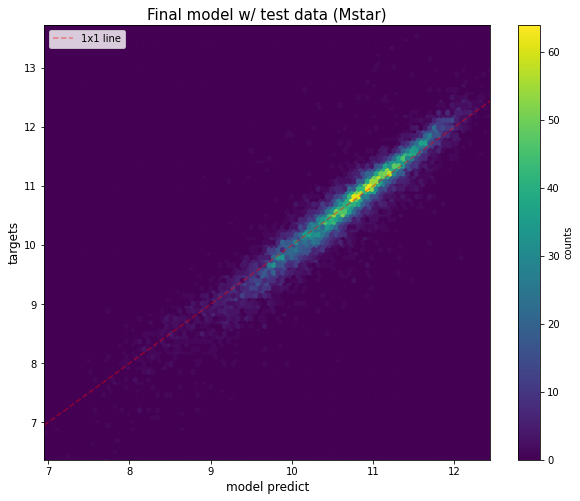

In [16]:
# Creating the plot
fig = plt.figure(figsize=(10, 8))

# Plotting the un-scaled predictions and targets
hb = plt.hexbin(x, y, gridsize=100, cmap='viridis')
plt.plot([min(x), max(x)], [min(x), max(x)], '--r', alpha=0.4, label='1x1 line')

# Just some cosmetic code
plt.axis([min(x), max(x), min(y), max(y)])
plt.title(f"Final model w/ test data ({param})", fontsize=15)
plt.xlabel("model predict", fontsize=12)
plt.ylabel("targets", fontsize=12)
cb = fig.colorbar(hb, ax=fig.axes)
cb.set_label('counts')
plt.legend(loc="upper left")
plt.show()

---

# 4. Conclusions and future work

In this project, which is the basis for my Master's thesis, we managed to train a Neural Network that can **reliably** obtain some select STARLIGHT parameters directly from S-PLUS photometry. 

Despite only showing the analysis for one parameter (stellar mass), you can go back and change the parameter to see their different results. It should be noted that each parameter requires an specific change to the architecture in order to achieve its best fit, but this part is still being worked on. Most parameters still can't fit as well as the stellar mass, and we need to decide based on its test metrics if it is worth applying the model to real data or not.

There a lot that can be done to try to improve this work. A more complete analysis of the training data can be done, we can try to change the architecture to use DenseVariational layers, or maybe have a better grasp of the model's metrics by using another type of cross-validation. Still, we are quite happy with the results presented here and we'll try to improve the model as best as we can.

In the following months we aim to apply all models that worked well (based on a few tresholds that are yet to be set) to **real** S-PLUS objects that still doesn't have these parameters known. We especially have a lot of interest in studying objects in the Fornax region.

---

# 5. Bibliography

Chollet, F. (2018). Deep Learning with Python. Shelter Island, NY: Manning Publications

Chollet F., et al. 2015. Keras. https://keras.io

Cid Fernandes R., Mateus A., Sodre L., Staninka G., Gomes J. M. (2005). MNRAS, 358,363

Mendes de Oliveira C., et al. (2019). MNRAS, 489, 241-267

Werle, A. 2019. Analisys of SDSS spectra and GALEX photometry with STARLIGHT: stellar populations and dust attenuation in local galaxies. Universidade Federal de Santa Catarina, Santa Catarina, Brazil

Werle A., Cid Fernandes R., Vale Asari N., et al. (2018). MNRAS, 483, 2382-2397